In [ ]:
#Kết nối với drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

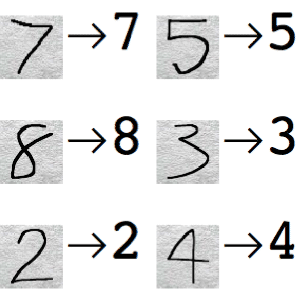

11490434/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


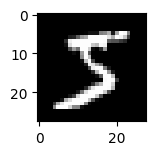

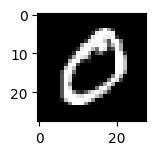

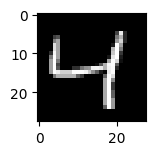

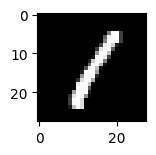

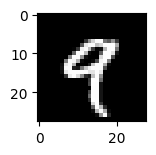

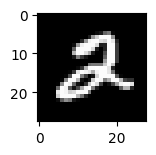

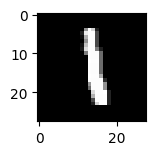

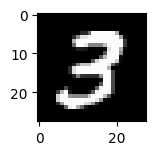

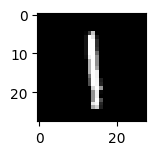

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

Cài đặt thư viện cần thiết.

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [ ]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [ ]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

Đề xuất một mô hình mạng CNN mới với các lớp sau:
- Thêm các lớp Convolutional kết hợp với hàm kích hoạt ReLU và chuẩn hóa BatchNormalization với kích thước kernel tăng và thêm tham số strides để giảm kích thước của feature map. Để tránh overfitting, sau mỗi lớp Convolution cuối cùng trong mỗi block sẽ sử dụng Dropout với tỷ lệ 0.4.
- Sau các lớp trên, sử dụng Flatten layer để chuyển về thành vector 1 chiều để có thể kết nối với lớp Dense.
- Thêm lớp Fully Connected (Dense) với 10 nơ-ron và hàm kích hoạt softmax để đưa ra dự đoán cho 10 lớp khác nhau.
- Sử dụng hàm optimizer Adam thay vì SGD để tối ưu hóa mô hình.

Nguồn tham khảo: here https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [ ]:
def define_model_new():
    model = Sequential()

    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))


  # compile model

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

## Evaluate Model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

Đánh giá model mới

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model_new(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model_new()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [ ]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.650
> 98.692
> 98.558
> 98.875
> 98.867


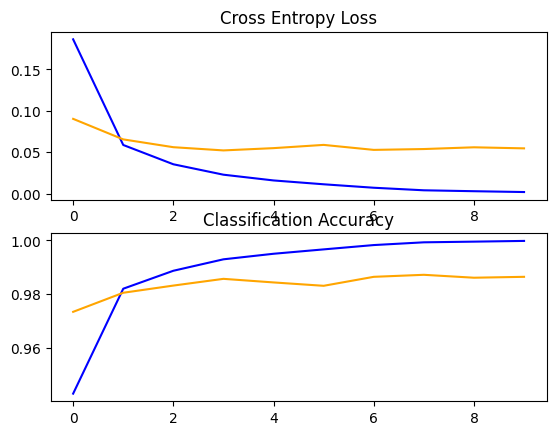

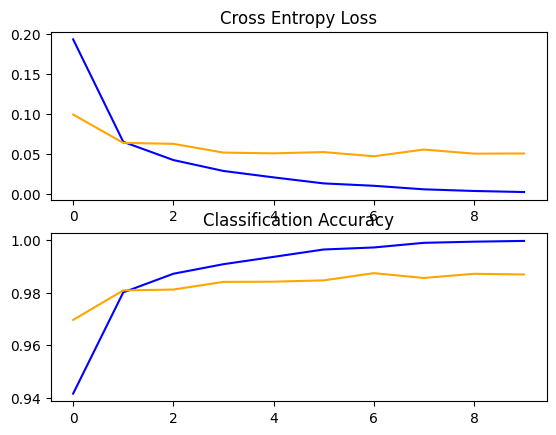

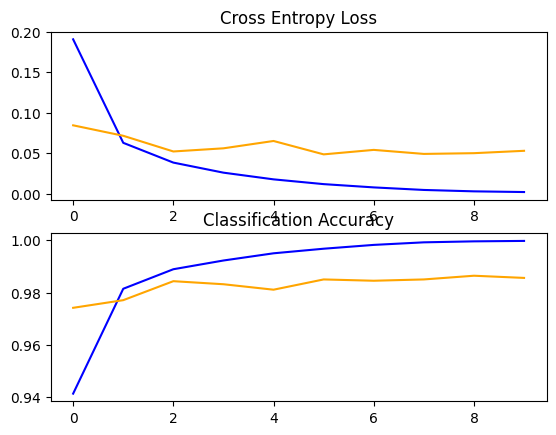

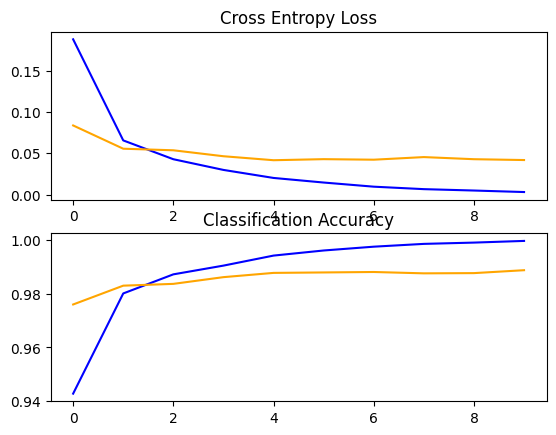

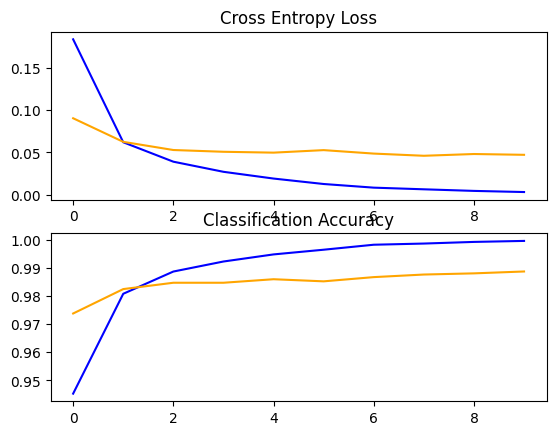

Accuracy: mean=98.728 std=0.124, n=5


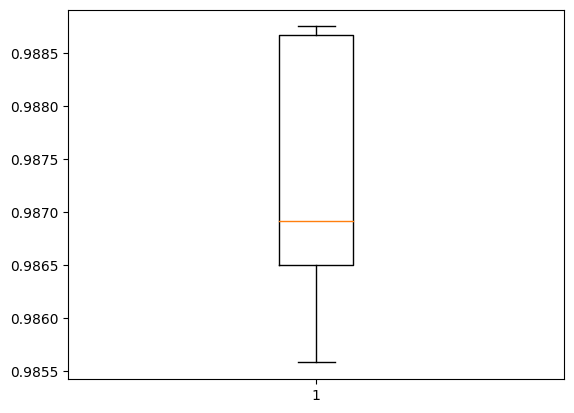

In [ ]:
# entry point, run the test harness
run_test_harness()

In [ ]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model_5.h5')
run_test_harness2()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model mới

In [40]:
# run the test harness for evaluating a model
def run_test_harness2_new():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model_new()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model_5_new.h5')

run_test_harness2_new()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Prediction

In [31]:
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

Model cũ chưa chỉnh lại dữ liệu đầu vào.

In [44]:
import os

def run_example():
    # Đường dẫn đến thư mục chứa các tệp hình ảnh
    folder_path = '/content/drive/MyDrive/SoVietTay'

    # Lặp qua tất cả các tệp trong thư mục
    count=0
    count_total = 0
    for mssv in os.listdir(folder_path):
      for folder in os.listdir('/content/drive/MyDrive/SoVietTay/'+mssv):
        for img in os.listdir('/content/drive/MyDrive/SoVietTay/'+mssv+'/'+folder):
          count_total += 1
          # Kiểm tra xem tệp có phải là một tệp hình ảnh không
          if img.endswith('.jpg') or img.endswith('.png'):
              # Xây dựng đường dẫn đầy đủ đến tệp
              image_path = os.path.join('/content/drive/MyDrive/SoVietTay/'+mssv+'/'+folder, img)
              img_ = load_image(image_path)
              # load model
              model = load_model('final_model_5.h5')

              # predict the class
              predict_value = model.predict(img_)

              digit = argmax(predict_value)

              if str(digit) == img[0]:
                count+=1
                print("Predicted digit for", img, "is:", digit)
                #plt.subplot(330 + 1 + i)
              # plot raw pixel data
                #img_ = img_.reshape(28,28)
                #plt.imshow(img_, cmap=plt.get_cmap('gray'))
              # show the figure
                #plt.show()
    print("Model cũ: ",count, '/', count_total)

Model mới
- Chỉnh sửa hình ảnh đầu vào thành ảnh nền đen chữ trắng thay vì chữ trắng nền đen để tăng độ chính xác thông qua việc dùng `int(1.5 - pixel)`. Bên cạnh đó, việc làm tròn số sẽ giúp ảnh nét hơn.

In [49]:
import os

def run_example_new():
    # Đường dẫn đến thư mục chứa các tệp hình ảnh
    folder_path = '/content/drive/MyDrive/SoVietTay'

    # Lặp qua tất cả các tệp trong thư mục
    count=0
    count_total = 0
    for mssv in os.listdir(folder_path):
      for folder in os.listdir('/content/drive/MyDrive/SoVietTay/'+mssv):
        for img in os.listdir('/content/drive/MyDrive/SoVietTay/'+mssv+'/'+folder):
          count_total += 1
          # Kiểm tra xem tệp có phải là một tệp hình ảnh không
          if img.endswith('.jpg') or img.endswith('.png'):
              # Xây dựng đường dẫn đầy đủ đến tệp
              image_path = os.path.join('/content/drive/MyDrive/SoVietTay/'+mssv+'/'+folder, img)

              # Load hình ảnh từ tệp
              img_ = load_image(image_path)
              for i in range(img_.shape[0]):
                for j in range(img_.shape[1]):
                  for m in range(img_.shape[2]):
                    for n in range(img_.shape[3]):
                      img_[i][j][m][n] = int(1.5-img_[i][j][m][n])

              # load model
              model = load_model('final_model_5_new.h5')

              # predict the class
              predict_value = model.predict(img_)

              digit = argmax(predict_value)

              if str(digit) == img[0]:
                count+=1
                print("Predicted digit for", img, "is:", digit)
              #plt.subplot(330 + 1 + i)
            # plot raw pixel data
              #img_ = img_.reshape(28,28)
              #plt.imshow(img_, cmap=plt.get_cmap('gray'))
            # show the figure
              #plt.show()

    print("Model mới: ",count, '/', count_total)

Model cũ đã được chỉnh sửa dữ liệu đầu vào như trên:

In [53]:
import os

def run_example_datanew():
    # Đường dẫn đến thư mục chứa các tệp hình ảnh
    folder_path = '/content/drive/MyDrive/SoVietTay'

    # Lặp qua tất cả các tệp trong thư mục
    count=0
    count_total = 0
    for mssv in os.listdir(folder_path):
      for folder in os.listdir('/content/drive/MyDrive/SoVietTay/'+mssv):
        for img in os.listdir('/content/drive/MyDrive/SoVietTay/'+mssv+'/'+folder):
          count_total += 1
          # Kiểm tra xem tệp có phải là một tệp hình ảnh không
          if img.endswith('.jpg') or img.endswith('.png'):
              # Xây dựng đường dẫn đầy đủ đến tệp
              image_path = os.path.join('/content/drive/MyDrive/SoVietTay/'+mssv+'/'+folder, img)

              # Load hình ảnh từ tệp
              img_ = load_image(image_path)
              for i in range(img_.shape[0]):
                for j in range(img_.shape[1]):
                  for m in range(img_.shape[2]):
                    for n in range(img_.shape[3]):
                      img_[i][j][m][n] = int(1.5-img_[i][j][m][n])

              # load model
              model = load_model('final_model_5.h5')

              # predict the class
              predict_value = model.predict(img_)

              digit = argmax(predict_value)

              if str(digit) == img[0]:
                count+=1
                print("Predicted digit for", img, "is:", digit)
              #plt.subplot(330 + 1 + i)
            # plot raw pixel data
              #img_ = img_.reshape(28,28)
              #plt.imshow(img_, cmap=plt.get_cmap('gray'))
            # show the figure
              #plt.show()

    print("Model mới: ",count, '/', count_total)

In [ ]:
# entry point, run the example
run_example()
run_example_new()
run_example_datanew()

1/1 [==============================] - 0s 86ms/step
Predicted digit for 3 (1).jpg is: 3
1/1 [==============================] - 0s 50ms/step
Predicted digit for 8 (1).jpg is: 8
1/1 [==============================] - 0s 51ms/step
Predicted digit for 8 (4).jpg is: 8
1/1 [==============================] - 0s 51ms/step
Predicted digit for 8.jpg is: 8
1/1 [==============================] - 0s 55ms/step
Predicted digit for 8 (2).jpg is: 8
1/1 [==============================] - 0s 51ms/step
Predicted digit for 0 (2).jpg is: 0
1/1 [==============================] - 0s 54ms/step
Predicted digit for 8 (3).jpg is: 8
1/1 [==============================] - 0s 56ms/step
Predicted digit for 8 (1).jpg is: 8
1/1 [==============================] - 0s 55ms/step
Predicted digit for 8.jpg is: 8
1/1 [==============================] - 0s 54ms/step
Predicted digit for 8 (2).jpg is: 8
1/1 [==============================] - 0s 59ms/step
Predicted digit for 8 (4).jpg is: 8
1/1 [==============================] - 0

# Thống kê kết quả
Model cũ chưa chỉnh dữ liệu đầu vào: Có 12/100 ảnh được dự đoán đúng, trong đó có:
- 2/10 ảnh số 3
- 9/10 ảng số 8
- 1/10 ảnh số 0

Model cũ đã được chỉnh dữ liệu đầu vào: Có 66/100 ảnh được dự đoán đúng, trong đó có:
- 4/10 ảnh số 0
- 5/10 ảnh số 1
- 7/10 ảnh số 2
- 9/10 ảnh số 3
- 10/10 ảnh số 4
- 6/10 ảnh số 5
- 6/10 ảnh số 6
- 5/5 ảnh số 7
- 6/10 ảnh số 8
- 8/10 ảnh số 9

Model mới: Có 92/100 ảnh được dự đoán đúng, trong đó có:
- 10/10 ảnh số 0
- 10/10 ảnh số 1
- 8/10 ảnh số 2
- 10/10 ảnh số 3
- 9/10 ảnh số 4
- 10/10 ảnh số 5
- 9/10 ảnh số 6
- 8/10 ảnh số 7
- 10/10 ảnh số 8
- 8/10 ảnh số 9